# Домашнее задание № 9. Предобученные трансформеры 

### Задание 1 (8 баллов).
Дообучите 3 предобученных модели на тех же данных, что и в семинаре. Сравните качество и выберите лучшую. 
Модели должны отличаться друг от друга не только параметрами ru/en/multilingual, base/large, cased/uncased. Все три выбранные модели должны работать лучше, чем бейзлайн без дообучения (т.е. если модель не работает, попробуйте другую).




In [ ]:
!pip install sklearn pandas matplotlib transformers

     |████████████████████████████████| 4.2 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 38.3 MB/s 
     |████████████████████████████████| 6.6 MB 31.5 MB/s 
     |████████████████████████████████| 84 kB 2.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


# tf и huggingface 
import tensorflow as tf
from transformers import TFAutoModel
from transformers import AutoTokenizer

In [ ]:
data = pd.read_csv('lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)

In [ ]:
from sklearn.metrics import classification_report

def fit_model(tokenizer, model_bert):
  X = []

  for text in data.title:
      ids = tokenizer.encode(text)
      
      X.append(ids[:512])

  X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

  id2label = {i:label for i, label in enumerate(set(data.topic.values))}
  label2id = {l:i for i, l in id2label.items()}

  y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

  train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

  X_train, y_train = X[train_index], y[train_index]
  X_valid, y_valid = X[valid_index], y[valid_index]

  input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                  name="input_ids")

  output = model_bert({"input_ids":input_word_ids})
  drop = tf.keras.layers.Dropout(0.3)(output[0][:, 0]) 
  dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

  model_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)


  model_clf.compile(tf.optimizers.Adam(learning_rate=2e-6,
                                      ), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy', 
                            tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])
  

  model_clf.fit(X_train, y_train, 
      validation_data=(X_valid, y_valid),
      batch_size=2,
      epochs=20)
  
  print(model_clf.history.history.keys())
  plt.plot(model_clf.history.history['accuracy'])
  plt.plot(model_clf.history.history['val_accuracy'])
  plt.title('model rec_prec')
  plt.ylabel('rec_prec')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  pred = model_clf.predict(X_valid, batch_size=5).argmax(1)

  print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                        target_names=list(label2id), zero_division=0))

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('Skoltech/russian-sensitive-topics')
model_bert = TFAutoModel.from_pretrained('Skoltech/russian-sensitive-topics')

Downloading:   0%|          | 0.00/524 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/18.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/680M [00:00<?, ?B/s]

Some layers from the model checkpoint at Skoltech/russian-sensitive-topics were not used when initializing TFBertModel: ['dropout_37', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at Skoltech/russian-sensitive-topics.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20
288/288 [==============================] - 199s 643ms/step - loss: 3.0932 - accuracy: 0.0781 - rec_prec: 0.0000e+00 - val_loss: 2.7093 - val_accuracy: 0.0645 - val_rec_prec: 0.0000e+00
Epoch 2/20
288/288 [==============================] - 181s 627ms/step - loss: 2.9947 - accuracy: 0.0729 - rec_prec: 0.0017 - val_loss: 2.5154 - val_accuracy: 0.1613 - val_rec_prec: 0.0645
Epoch 3/20
288/288 [==============================] - 180s 626ms/step - loss: 2.5421 - accuracy: 0.2170 - rec_prec: 0.0087 - val_loss: 2.0824 - val_accuracy: 0.4194 - val_rec_prec: 0.0323
Epoch 4/20
288/288 [==============================] - 180s 626ms/step - loss: 2.1592 - accuracy: 0.3281 - rec_prec: 0.0451 - val_loss: 1.9086 - val_accuracy: 0.4839 - val_rec_prec: 0.1290
Epoch 5/20
288/288 [==============================] - 180s 626ms/step - loss: 1.8330 - accuracy: 0.4236 - rec_prec: 0.1319 - val_loss: 1.6479 - val_accuracy: 0.5806 - val_rec_prec: 0.2258
Epoch 6/20
288/288 [==============================] 

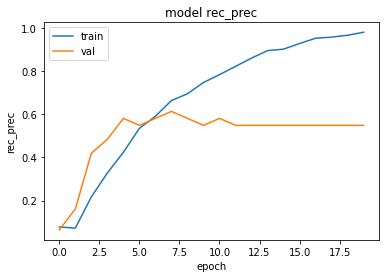

                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         1
          Легпром       0.00      0.00      0.00         1
  Наука и техника       1.00      0.67      0.80         3
         Из жизни       0.50      0.33      0.40         3
             Крым       0.00      0.00      0.00         0
      Бывший СССР       0.60      1.00      0.75         3
   Интернет и СМИ       0.00      0.00      0.00         2
Силовые структуры       0.50      1.00      0.67         2
              Дом       1.00      1.00      1.00         2
            Спорт       0.67      1.00      0.80         2
       Библиотека       0.00      0.00      0.00         0
              Мир       0.00      0.00      0.00         1
         Ценности       0.00      0.00      0.00         2
         Культура       0.60      1.00      0.75         3
           Россия       0.00      0.00      0.00         2
           Бизнес       0.00      0.00      0.00       

In [ ]:
fit_model(tokenizer, model_bert)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased')
model_bert = TFAutoModel.from_pretrained('distilbert-base-multilingual-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/20
288/288 [==============================] - 109s 353ms/step - loss: 2.8260 - accuracy: 0.0712 - rec_prec: 0.0000e+00 - val_loss: 2.7342 - val_accuracy: 0.1290 - val_rec_prec: 0.0000e+00
Epoch 2/20
288/288 [==============================] - 99s 343ms/step - loss: 2.7618 - accuracy: 0.0816 - rec_prec: 0.0000e+00 - val_loss: 2.7242 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 3/20
288/288 [==============================] - 98s 342ms/step - loss: 2.7530 - accuracy: 0.0868 - rec_prec: 0.0000e+00 - val_loss: 2.7212 - val_accuracy: 0.0000e+00 - val_rec_prec: 0.0000e+00
Epoch 4/20
288/288 [==============================] - 99s 344ms/step - loss: 2.7237 - accuracy: 0.1042 - rec_prec: 0.0000e+00 - val_loss: 2.6709 - val_accuracy: 0.1290 - val_rec_prec: 0.0000e+00
Epoch 5/20
288/288 [==============================] - 99s 343ms/step - loss: 2.6244 - accuracy: 0.1528 - rec_prec: 0.0035 - val_loss: 2.5787 - val_accuracy: 0.2258 - val_rec_prec: 0.0000e+00
Epoch 6/20
288/288 [====

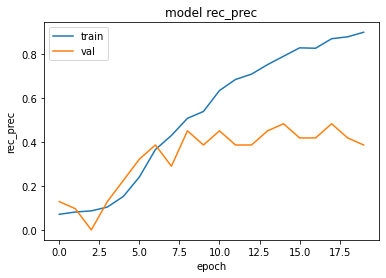

                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         1
          Легпром       0.00      0.00      0.00         1
  Наука и техника       0.50      0.33      0.40         3
         Из жизни       1.00      0.33      0.50         3
             Крым       0.00      0.00      0.00         0
      Бывший СССР       0.40      0.67      0.50         3
   Интернет и СМИ       0.50      0.50      0.50         2
Силовые структуры       1.00      0.50      0.67         2
              Дом       0.33      0.50      0.40         2
            Спорт       0.50      0.50      0.50         2
       Библиотека       0.00      0.00      0.00         0
              Мир       0.00      0.00      0.00         1
         Ценности       1.00      1.00      1.00         2
         Культура       0.33      0.33      0.33         3
           Россия       0.00      0.00      0.00         2
           Бизнес       0.25      0.50      0.33       

In [ ]:
fit_model(tokenizer, model_bert)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('salti/bert-base-multilingual-cased-finetuned-squad')
model_bert = TFAutoModel.from_pretrained('salti/bert-base-multilingual-cased-finetuned-squad')

Downloading:   0%|          | 0.00/264 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/822 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/676M [00:00<?, ?B/s]

Some layers from the model checkpoint at salti/bert-base-multilingual-cased-finetuned-squad were not used when initializing TFBertModel: ['qa_outputs']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at salti/bert-base-multilingual-cased-finetuned-squad and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
288/288 [==============================] - 198s 641ms/step - loss: 3.0013 - accuracy: 0.0677 - rec_prec: 0.0000e+00 - val_loss: 2.7590 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 2/20
288/288 [==============================] - 180s 626ms/step - loss: 2.8649 - accuracy: 0.0660 - rec_prec: 0.0000e+00 - val_loss: 2.7311 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 3/20
288/288 [==============================] - 180s 625ms/step - loss: 2.8530 - accuracy: 0.0712 - rec_prec: 0.0000e+00 - val_loss: 2.7205 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 4/20
288/288 [==============================] - 180s 624ms/step - loss: 2.8722 - accuracy: 0.0469 - rec_prec: 0.0000e+00 - val_loss: 2.7074 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 5/20
288/288 [==============================] - 180s 624ms/step - loss: 2.8219 - accuracy: 0.0747 - rec_prec: 0.0000e+00 - val_loss: 2.6915 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 6/20
288/288 [

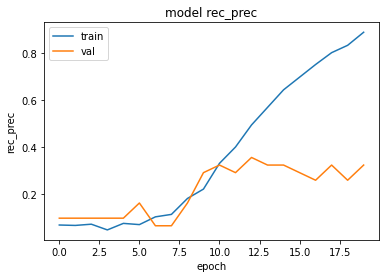

                   precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00         1
          Легпром       0.00      0.00      0.00         1
  Наука и техника       0.50      0.33      0.40         3
         Из жизни       0.00      0.00      0.00         3
             Крым       0.00      0.00      0.00         0
      Бывший СССР       0.29      0.67      0.40         3
   Интернет и СМИ       0.50      0.50      0.50         2
Силовые структуры       0.33      0.50      0.40         2
              Дом       0.33      0.50      0.40         2
            Спорт       1.00      1.00      1.00         2
       Библиотека       0.00      0.00      0.00         0
              Мир       0.00      0.00      0.00         1
         Ценности       0.00      0.00      0.00         2
         Культура       0.00      0.00      0.00         3
           Россия       0.12      0.50      0.20         2
           Бизнес       0.50      0.50      0.50       

In [ ]:
fit_model(tokenizer, model_bert)

Лучше всего себя показала модель от Сколково. Скорее всего это связано с тем, что она была обучена на русском языке, когда как другие модели тренировались на мультиязычных датасетах.

### Задание  2 (2 балла)

Ответьте на следующие вопросы (напишите хотя бы по несколько предложений):

1) Чем ROBERTA отличается от BERT? В какой статье описана ROBERTA?

2) Чем модель T5 отличается от ROBERTA/BERT? 

1) ROBERTA описана в статье https://arxiv.org/abs/1907.11692. Отличие ROBERTA от BERT состоит в том, что ROBERTA использует динамическое маскирование. У ROBERTA маскирование применяется каждый раз, когда какая-нибудь последовательность скармливается модели. Такой подход позволяет улучшить производительность в случае большого датасета или количества шагов.

2) Основное различие T5 от BERT-моделей в том, что первая модель на входе и выходе имеет текст. BERT-модели же на выходе предоставляют только какую-нибудь метку класса или диапазон входных данных.
